In [1]:
from collections import deque
from dataclasses import dataclass
import random

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from vizdoom import DoomGame
from skimage import transform
import matplotlib.pyplot as plt

In [2]:
ACTION_SIZE = 3
FRAME_STACK_SIZE = 4
STATE_SIZE = (4, 84, 84)

TOTAL_EPISODES = 500
LEARNING_RATE = 0.0002
BATCH_SIZE = 64
MAX_STEPS = 100
DISCOUNT_RATE = 0.95

EXPLORATION_RATE_MAX = 1.0
EXPLORATION_RATE_MIN = 0.01
EXPLORATION_RATE_DECAY = 0.005

INITIAL_MEMORY_SIZE = 10_000
MEMORY_SIZE = 1_000_000

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def create_enviorment(set_window_visible=False):
    game = DoomGame()
    game.load_config("basic.cfg")
    game.set_doom_scenario_path("basic.wad")
    game.set_window_visible(set_window_visible)
    game.init()
    left = [1, 0, 0]
    right = [0, 1, 0]
    shoot = [0, 0, 1]
    actions = torch.LongTensor([left, right, shoot])
    return game, actions

In [5]:
game, possible_actions = create_enviorment()
game.new_episode()
state = game.get_state()
variables = state.game_variables
frame = state.screen_buffer
game.close()

In [6]:
def preprocess_frame(frame):
    preprocessed_frame = np.copy(frame)
    preprocessed_frame = preprocessed_frame.mean(axis=0)
    preprocessed_frame = preprocessed_frame[30:-20, 30:-30]
    preprocessed_frame /= 255
    preprocessed_frame = transform.resize(preprocessed_frame, [84, 84])
    return preprocessed_frame

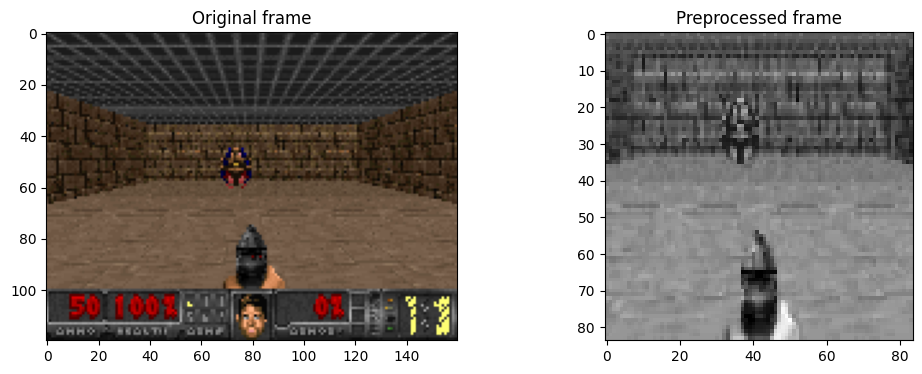

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(frame.transpose(1, 2, 0))
ax[0].set_title("Original frame")
ax[1].imshow(preprocess_frame(frame), cmap="gray")
ax[1].set_title("Preprocessed frame")
plt.show()

In [8]:
class FrameStack:
    def __init__(self, stack_size=FRAME_STACK_SIZE):
        self.stack_size = stack_size
        self.reset_frame_stack()

    def reset_frame_stack(self):
        self.frames = deque(
            [np.zeros((84, 84), dtype=np.uint8) for _ in range(self.stack_size)],
            maxlen=self.stack_size,
        )

    def stack(self, frame, is_new_episode=False):
        if is_new_episode:
            self.reset_frame_stack()
            for _ in range(self.stack_size):
                self.frames.append(frame)
        else:
            self.frames.append(frame)

        return np.stack(self.frames, axis=0)

In [9]:
class DeepQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DeepQNetwork, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=state_size[0], out_channels=32, kernel_size=8, stride=4
        )
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=4, stride=2
        )
        # 4x84x84 -> conv1(84x84) = 32x20x20 -> conv2(20x20) = 64x9x9 -> conv3(9x9) = 128x3x3 = 1152
        self.fc1 = nn.Linear(in_features=1152, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=action_size)
        self.elu = nn.ELU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.elu(x)
        x = self.conv2(x)
        x = self.elu(x)
        x = self.conv3(x)
        x = self.elu(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.elu(x)
        x = self.fc2(x)
        return x

In [10]:
class ExperienceBuffer:
    @dataclass(frozen=True)
    class Experience:
        state: np.ndarray
        action: list[int]
        reward: int
        next_state: np.ndarray
        is_episode_finished: bool

    def __init__(self, memory_size: int, frame_stack: FrameStack):
        self.experience_buffer = deque(maxlen=memory_size)
        self.frame_stack = frame_stack
        self.initialize_experience_buffer()

    def add(self, experience):
        self.experience_buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.experience_buffer, batch_size)

    def initialize_experience_buffer(self):
        game, possible_actions = create_enviorment()

        while len(self.experience_buffer) < INITIAL_MEMORY_SIZE:
            game.new_episode()
            frame = preprocess_frame(game.get_state().screen_buffer)
            state = self.frame_stack.stack(frame, True)

            while True:
                action = random.choice(possible_actions.tolist())
                reward = game.make_action(action)
                is_episode_finished = game.is_episode_finished()

                if is_episode_finished:
                    next_state = np.zeros(state.shape)
                    self.add(
                        ExperienceBuffer.Experience(
                            state, action, reward, next_state, is_episode_finished
                        )
                    )
                    break

                frame = preprocess_frame(game.get_state().screen_buffer)

                next_state = self.frame_stack.stack(frame)
                self.add(
                    ExperienceBuffer.Experience(
                        state, action, reward, next_state, is_episode_finished
                    )
                )
                state = next_state

        game.close()

In [11]:
def predict_action(model: nn.Module, state, episode, possible_actions):
    exploration_probability = EXPLORATION_RATE_MIN + (
        EXPLORATION_RATE_MAX - EXPLORATION_RATE_MIN
    ) * np.exp(-EXPLORATION_RATE_DECAY * episode)
    
    if np.random.rand() < exploration_probability:
        return random.choice(possible_actions.tolist())
    else:
        model.eval()
        with torch.no_grad():
            return possible_actions[
                model(
                    torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                )
                .argmax(dim=1)
                .item()
            ].tolist()

In [ ]:
def train(
    model: nn.Module,
    optimizer: optim.Optimizer,
    criterion,
    experience_buffer: ExperienceBuffer,
    frame_stack: FrameStack,
):
    game, possible_actions = create_enviorment()
    rewards = []
    for episode in range(TOTAL_EPISODES):
        game.new_episode()
        frame = preprocess_frame(game.get_state().screen_buffer)
        state = frame_stack.stack(frame, is_new_episode=True)
        episode_rewards = 0
        for _ in range(MAX_STEPS):
            # Enviorment interaction phase
            action = predict_action(model, state, episode, possible_actions)
            reward = game.make_action(action)
            episode_rewards += reward
            is_episode_finished = game.is_episode_finished()

            if is_episode_finished:
                next_state = np.zeros(state.shape)
            else:
                next_state = frame_stack.stack(
                    preprocess_frame(game.get_state().screen_buffer)
                )

            experience_buffer.add(
                ExperienceBuffer.Experience(
                    state, action, reward, next_state, is_episode_finished
                )
            )
            state = next_state

            # Model training phase
            batch = experience_buffer.sample(BATCH_SIZE)
            states_batch = torch.tensor(np.array([exp.state for exp in batch]),dtype=torch.float32,device=device)
            actions_batch = torch.tensor(np.array([exp.action for exp in batch]),dtype=torch.int64,device=device)
            rewards_batch = torch.tensor(np.array([exp.reward for exp in batch]),dtype=torch.float32,device=device)
            next_states_batch = torch.tensor(np.array([exp.next_state for exp in batch]),dtype=torch.float32,device=device)
            is_episode_finished_batch = torch.tensor(np.array([exp.is_episode_finished for exp in batch]),dtype=torch.bool,device=device)

            model.eval()
            with torch.no_grad():
                next_q_values = model(next_states_batch).max(dim=1).values
                target_q_values = (
                    rewards_batch
                    + DISCOUNT_RATE * next_q_values * ~is_episode_finished_batch
                )

            model.train()
            optimizer.zero_grad()
            predicted_q_values = (
                model(states_batch)
                .gather(1, actions_batch.argmax(dim=1).unsqueeze(1))
                .squeeze(1)
            )
            loss = criterion(predicted_q_values, target_q_values)
            loss.backward()
            optimizer.step()

            if is_episode_finished:
                break

        print(
            f"Episode: {episode + 1}, Total reward: {episode_rewards}, Loss: {loss.item()}, Exploration rate: {EXPLORATION_RATE_MIN + (EXPLORATION_RATE_MAX - EXPLORATION_RATE_MIN) * np.exp(-EXPLORATION_RATE_DECAY * episode)}"
        )

        rewards.append(episode_rewards)

    game.close()
    return rewards

In [13]:
model = DeepQNetwork(STATE_SIZE, ACTION_SIZE).to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()
experience_buffer = ExperienceBuffer(MEMORY_SIZE, FrameStack())
frame_stack = FrameStack()
rewards = train(model, optimizer, criterion, experience_buffer, frame_stack)

Episode: 1, Total reward: 95.0, Loss: 28.528270721435547, Exploration rate: 1.0
Episode: 2, Total reward: 94.0, Loss: 1444.779052734375, Exploration rate: 0.9950623544007555
Episode: 3, Total reward: -125.0, Loss: 2.3804097175598145, Exploration rate: 0.9901493354116764
Episode: 4, Total reward: -130.0, Loss: 2.0558536052703857, Exploration rate: 0.985260820207032
Episode: 5, Total reward: 13.0, Loss: 1.0607731342315674, Exploration rate: 0.9803966865736877
Episode: 6, Total reward: 77.0, Loss: 3.515678882598877, Exploration rate: 0.9755568129080493
Episode: 7, Total reward: 89.0, Loss: 3.1723742485046387, Exploration rate: 0.970741078213023
Episode: 8, Total reward: 94.0, Loss: 1.5332496166229248, Exploration rate: 0.9659493620949908
Episode: 9, Total reward: 22.0, Loss: 159.94549560546875, Exploration rate: 0.9611815447608
Episode: 10, Total reward: -125.0, Loss: 4.157588005065918, Exploration rate: 0.9564375070147689
Episode: 11, Total reward: 93.0, Loss: 3.4836349487304688, Explora

Text(0.5, 1.0, 'Cumulative rewards')

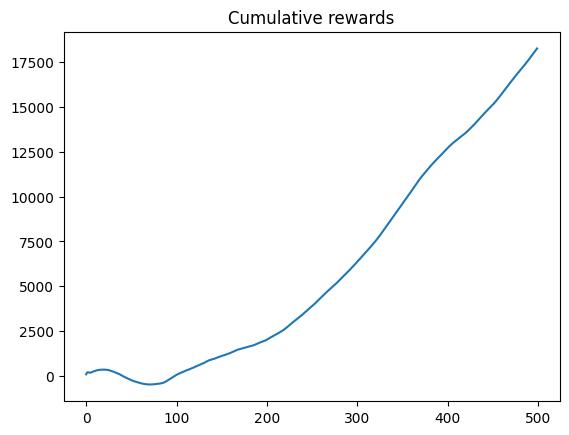

In [16]:
cumulative_rewards = np.cumsum([np.mean(rewards[max(0, i - 50) : i]) for i in range(1, len(rewards) + 1)])
plt.plot(cumulative_rewards)
plt.title("Cumulative rewards")

In [20]:
# See agent play
import time
game, possible_actions = create_enviorment(set_window_visible=True)
game.new_episode()
frame = preprocess_frame(game.get_state().screen_buffer)
state = frame_stack.stack(frame, is_new_episode=True)
while True:
    action = predict_action(model, state, 0, possible_actions)
    game.make_action(action)
    if game.is_episode_finished():
        break
    frame = preprocess_frame(game.get_state().screen_buffer)
    state = frame_stack.stack(frame)
    time.sleep(0.1)
game.close()